#EEG Epileptic Seizure dataset "manual" binary classification
You'll find step-by-step workflow for binary classification of the EEG data that is an option of the one used in single_channel.py. This notebook contains some more dataset specific preprocessing, data understanding and visualization blocks to be useful for analysis of another but similar EEG datasets.

In [0]:
# import all required packages and modules

from google.colab import files
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import diags
from scipy.special import gamma
from scipy.integrate import simps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from itertools import chain
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

Try to keep your code in functional programming style and define functionally distinguishable pieces of code as separate functions.

In [0]:
def delta(n, fex, feh):
    ex = np.kron([x for x in range(n-1, 0, -1)], np.ones((n,1)))
    if (n%2) == 0:
        dx = -np.pi**2/(3*feh**2)-(1/6)*np.ones((n,1))
        test_bx = -(-1)**ex*(0.5)/(np.sin(ex*feh*0.5)**2)
        test_tx =  -(-1)**(-ex)*(0.5)/(np.sin((-ex)*feh*0.5)**2)
    else:
        dx = -np.pi**2/(3*feh**2)-(1/12)*np.ones((n,1))
        test_bx = -0.5*((-1)**ex)*np.tan(ex*feh*0.5)**-1/(np.sin(ex*feh*0.5))
        test_tx = -0.5*((-1)**(-ex))*np.tan((-ex)*feh*0.5)**-1/(np.sin((-ex)*feh*0.5))

    rng = [x for x in range(-n+1, 1, 1)] + [y for y in range(n-1, 0, -1)]
    Ex = diags(np.concatenate((test_bx, dx, test_tx), axis = 1).T, np.array(rng), shape = (n, n)).toarray()
    Dx=(feh/fex)**2*Ex
    return Dx

def scsa(y, h):
    M = len(y.tolist())
    fe = 1
    feh = 2*np.pi/M
    D = delta(M,fe,feh)
    Y = np.diag(y)
    gm = 0.5
    Lcl = (1/(2*(np.pi)**0.5))*(gamma(gm+1)/gamma(gm+(3/2)))
    SC = -h*h*D-Y
    lamda, psi = np.linalg.eigh(SC)
    temp = np.diag(lamda)
    ind = np.where(temp < 0)
    temp = temp[temp < 0]
    kappa = np.diag((-temp)**gm)
    Nh = kappa.shape[0]
    psin = psi[:, ind[0]]
    I = simps(psin**2, dx = fe, axis = 0)
    psinnor = psin/I**0.5
    yscsa =((h/Lcl)*np.sum((psinnor**2)@kappa,1))**(2/(1+2*gm))
    if y.shape != yscsa.shape: yscsa = yscsa.T
    return yscsa, kappa, Nh, psinnor


def preproc(df):
    df.rename(columns={'Unnamed: 0':'indx'}, inplace=True)
    # Get patient_id and time of recording
    df['sec'], df['patient_id'] = df['indx'].str.split('.', 1).str
    df.drop(columns=['indx'], inplace=True)
    # Replace id with the corresponding numbers
    patient_map = dict(zip(df['patient_id'].unique(), list(range(1, 501))))
    df = df.replace({'patient_id': patient_map})
    df['sec'] = df['sec'].str[1:]
    df['sec'] = df['sec'].astype('int16')
    # reorder columns
    cols = ['patient_id', 'sec'] + list(df.columns[:-2])
    df = df[cols]
    # sort data by patient_id and time
    df.sort_values(['patient_id', 'sec'], inplace=True)
    # binarize target
    df['y'].loc[df['y'] > 1] = 0
    return df

In [0]:
# import and and have a look at our data
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
df = preproc(data)
display(df.head())
print(df.shape)
# make a copy of original dataset
df_copy = df.copy()

Saving data.csv to data.csv


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,patient_id,sec,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
4081,1,1,51,84,105,72,-21,-101,-134,-146,-119,-77,-32,33,112,163,176,155,93,42,4,-13,-32,-24,-4,21,22,38,55,65,31,17,17,-5,-9,-15,-21,-5,9,42,...,51,12,-43,-90,-110,-115,-94,-92,-77,-43,-12,4,12,17,9,-12,-31,-42,-42,-38,-1,7,-17,6,87,94,32,-25,-92,-119,-117,-97,-87,-51,-6,20,22,10,-16,0
573,1,2,-46,-69,-88,-94,-96,-108,-106,-105,-100,-55,-20,-22,-26,-29,-57,-91,-75,-77,-91,-68,-39,23,97,139,131,52,-18,-81,-109,-85,-81,-97,-125,-98,-31,9,20,2,...,-56,-107,-127,-123,-78,-26,3,44,33,4,18,23,22,-5,-31,-42,-46,-88,-91,-48,4,44,78,100,107,105,89,40,-25,-50,-42,-31,-29,-16,-7,-5,-19,-62,-76,0
413,1,3,-78,-93,-117,-130,-126,-66,9,77,143,133,84,36,21,-16,-43,-26,-13,49,129,194,207,197,163,69,-35,-111,-131,-140,-135,-88,-35,34,133,183,137,40,-70,-177,...,84,0,-47,-81,-87,-34,-24,-19,3,22,25,7,2,-22,-10,-2,-6,-35,-33,0,-14,-71,-92,-112,-79,-53,-37,-25,2,-6,-20,-60,-69,-74,-65,-40,-12,0,-1,0
298,1,4,-11,-57,-84,-109,-127,-147,-167,-152,-126,-97,-50,7,54,119,172,146,55,-29,-97,-175,-207,-191,-141,-107,-74,-39,-45,-28,-21,-35,-77,-104,-126,-147,-122,-78,-1,71,...,35,26,-12,-9,-5,-21,-61,-80,-111,-123,-95,-51,-15,10,7,-17,-40,-71,-37,-23,7,21,20,18,4,-21,-56,-46,-22,-31,-66,-99,-121,-140,-130,-73,-56,-47,-42,0
8489,1,5,-43,-64,-88,-113,-105,-104,-93,-78,-51,-14,14,36,-3,-55,-88,-102,-96,-80,-76,-58,-14,-1,24,56,70,59,55,25,-14,-42,-60,-95,-93,-72,-49,-31,-1,20,...,-159,-142,-102,-62,-29,18,48,111,133,94,33,-25,-57,-49,-39,-34,-15,20,9,-3,24,50,54,54,53,8,-30,-50,-63,-54,-45,-50,-52,-11,34,65,89,83,80,0


(11500, 181)


SCSA doesn't work with negative signals, thus we need to shift the signal to strictly non-negative domain


In [0]:
vals = df.drop(['patient_id','sec', 'y'], axis = 1)
vals = vals - vals.min().min()
df[vals.columns] = vals

#Semi-classical signal analysis
This section covers SCSA-based feature generation and some insights on its work.

In [0]:
# apply SCSA to generate new features 
# it's a time-consuming ~5 min procedure, so you may go and make some tea
%%time
ids = []
labels = []
eigens = []
Nh = []
for k in df['patient_id'].unique():
    temp = df[df['patient_id'] == k]
    labels.append(temp['y'].values)
    ids.append(temp['patient_id'].values)
    for i in temp['sec']:
        y = temp[temp['sec'] == i].drop(['patient_id','sec', 'y'], axis = 1).values[0]
        h = max(y)/20
        yscsa, kappa, n, psinnor = scsa(y, h)
        Nh.append(n)
        eigens.append(kappa.diagonal().tolist())   

# cut all eigenvectors to be the length of the smallest one present in the generated set
N = min(Nh)
X = np.array([eigens[i][:N] for i in range(len(eigens))])
# divide all the recordings by groups to prevent training and testing on the same subjects since it may cause biased estimation
y = np.array(list(chain.from_iterable(labels)))
groups = np.array(list(chain.from_iterable(ids)))

CPU times: user 5min 55s, sys: 3min 58s, total: 9min 53s
Wall time: 4min 58s


In [0]:
# create pipeline applied before cross-validation
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='linear', gamma='auto', 
                C=1, class_weight='balanced'))])

# evaluate pipeline

gkf = GroupKFold(n_splits=10).split(X, y, groups)
scoring = 'accuracy'
score = cross_val_score(pipe, X, y, cv=gkf, scoring=scoring, n_jobs=-1)
print('Mean Accuracy: ', np.mean(score))
print('Accuracy std: ', np.std(score))

gkf = GroupKFold(n_splits=10).split(X, y, groups)
scoring = 'roc_auc'
score = cross_val_score(pipe, X, y, cv=gkf, scoring=scoring, n_jobs=-1)
print('Mean ROC_AUC: ', np.mean(score))
print('ROC_AUC std: ', np.std(score))

Mean Accuracy:  0.97
Accuracy std:  0.007672404088618806
Mean ROC_AUC:  0.9911105408049595
ROC_AUC std:  0.011508783859145997


See what area under roc-curve is and why it is a good metric for binary classification.

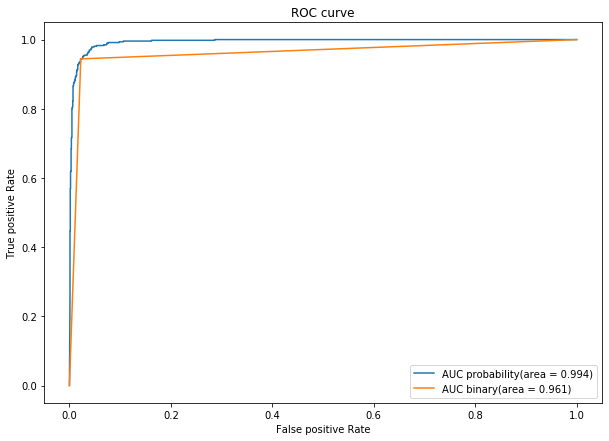

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = SVC(kernel='linear', gamma='auto', probability = 1, 
          C=1, class_weight='balanced')

y_pred = clf.fit(X_train, y_train).predict(X_test)
y_pred_prob = clf.fit(X_train, y_train).predict_proba(X_test)
y_pred_test = utils.to_categorical(y_test, 2)
y_pred_prob = y_pred_prob[:, 1]
y_pred_test = y_pred_test[:, 1]

plt.figure(figsize=(10, 7))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_pred_test, y_pred_prob)
AUC_prob = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='AUC probability(area = {:.3f})'.format(AUC_prob))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
AUC_acc = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='AUC binary(area = {:.3f})'.format(AUC_acc))

plt.xlabel('False positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Now let's try to melt some magic behind SCSA. Apply DecisionTreeClassifier to generated features and see based on what rules the classification happens.

In [0]:
# here we need more specific packages
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from subprocess import call
from IPython.display import Image

Since it is only high-level overiew of the method performance, there is no need in k-fold cross-validation


In [0]:
# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=17)
# define new classification model with default values of parameters
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
prediction = tree_model.predict(X_test)
acc_test = accuracy_score(y_test, prediction)
print(acc_test)

0.9591304347826087


Try to find an optimal depth of the Tree

Best params: {'max_depth': 6}
Best cross validaton score 0.9618633540372671


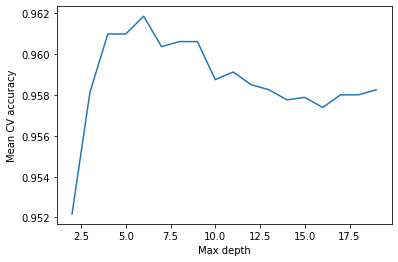

In [0]:
params_greed = {'max_depth': list(range(2, 20))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), 
                         params_greed, 
                         cv=5, scoring='accuracy') 

tree_grid.fit(X_train, y_train)

plt.plot(params_greed['max_depth'], 
         tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy')
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

In [0]:
# Tuned tree
tuned_tree = DecisionTreeClassifier(max_depth=6, random_state=17).fit(X_train, y_train)
prediction = tuned_tree.predict(X_test)
acc_test = accuracy_score(y_test, prediction)
print(acc_test)

0.9652173913043478


Now let's have a look at our feachures

In [0]:
# create feature dataframe from X array
feat = pd.DataFrame(data = X, columns = ['eigenvalue %s' % (i+1) for i in range(X.shape[1])])
feat.head()

,eigenvalue 1,eigenvalue 2,eigenvalue 3,eigenvalue 4,eigenvalue 5,eigenvalue 6,eigenvalue 7,eigenvalue 8,eigenvalue 9,eigenvalue 10,eigenvalue 11,eigenvalue 12
0,43.548874,43.500561,43.129780,42.788194,42.732066,42.003110,41.925557,40.904267,40.860087,39.455040,39.345132,37.754980
1,43.267351,42.944431,42.924996,42.631390,42.353098,41.801436,41.604295,40.726760,40.491414,39.255585,39.144068,37.505376
2,43.538078,43.451670,43.257233,42.742436,42.447549,41.883035,41.504641,40.588398,40.291267,39.010444,38.481170,36.843355
3,43.601287,43.034808,42.930559,42.605171,42.415121,41.889276,41.629692,40.585472,40.452614,39.218068,38.876553,37.219575
4,43.382995,43.236612,43.113400,42.794483,42.654854,42.077034,41.937098,40.954681,40.778020,39.579786,39.384667,37.951513


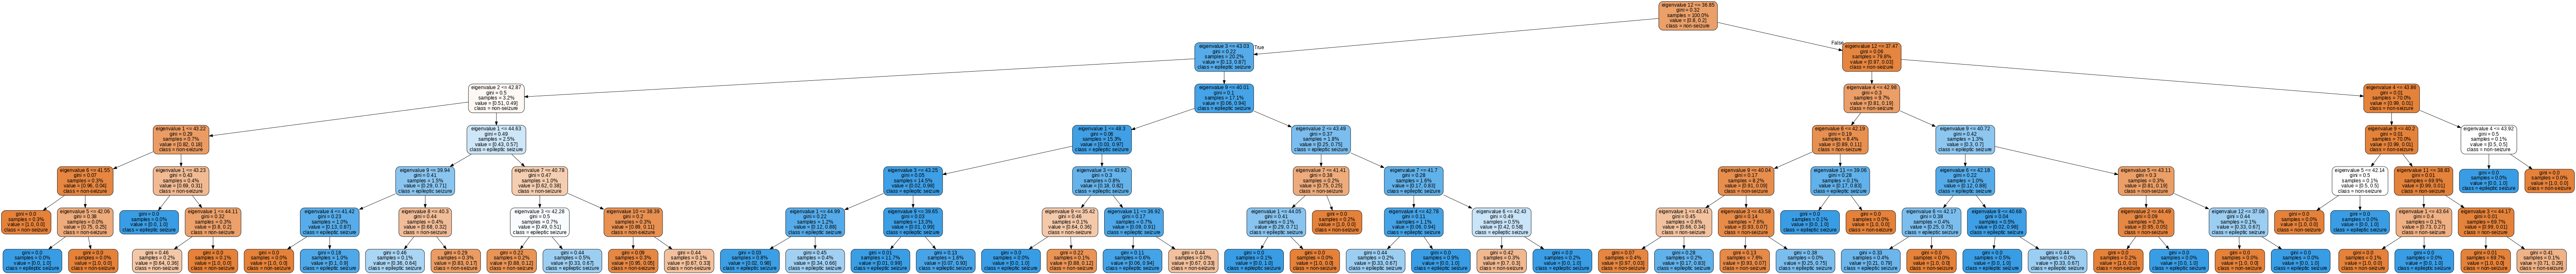

In [0]:
# plot DecisionTree nodes hierarchy
export_graphviz(tuned_tree, out_file='tree.dot', 
                feature_names = feat.columns,
                class_names = ['non-seizure', 'epileptic seizure'],
                rounded = True, proportion = True, 
                precision = 2, filled = True)

# convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=60'])

# display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

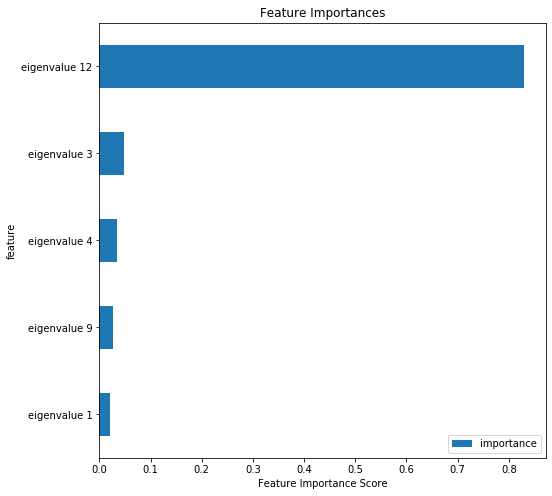

In [0]:
# plot top-5 feature importances
feat_imp = pd.DataFrame({'importance': tuned_tree.feature_importances_})    
feat_imp['feature'] = feat.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:5]
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importances", figsize=(5, 5))
plt.xlabel('Feature Importance Score')
plt.show()



---


Pretty curious fact: if you put another h value to scsa() function it will generate another number of features, but nevertheless the most important feature remains to be the last one (a border of cut-off).



---



#Neural Network
Try to use simple NN architecture and get similar results without any manual feature generation

In [0]:
# more packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import concatenate
from tensorflow.keras import utils
from keras import regularizers
from tensorflow.keras.preprocessing import image
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [0]:
# use unshifted data
y = df_copy['y']
X = df_copy.drop(['y', 'patient_id', 'sec'], axis=1)
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = utils.to_categorical(y_train, 2)
y_test = utils.to_categorical(y_test, 2)

In [0]:
model = Sequential()
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l1(0.001), input_shape = (178,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(2, activation="sigmoid"))
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                11456     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 15,746
Trainable params: 15,746
Non-trainable params: 0
_________________________________________________________________
None


Best train acc:  0.95985055
Best validation acc:  0.96766305


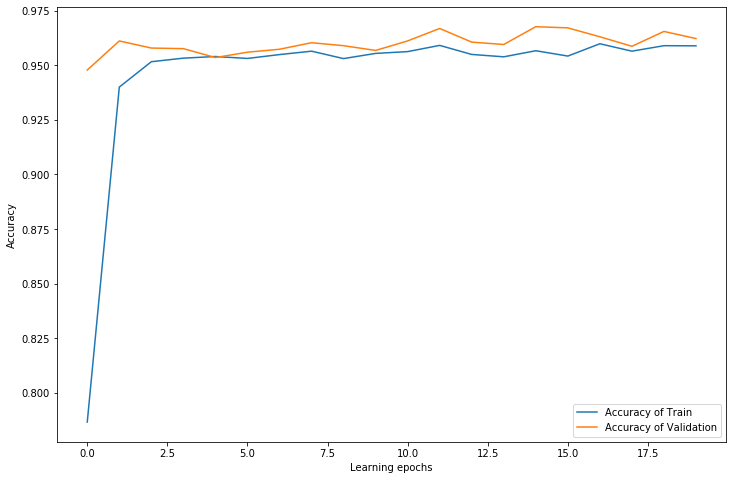

In [0]:
callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='acc', patience=5)]


history = model.fit(X_train,
                  y_train,
                  epochs=20,
                  callbacks=callbacks_list,
                  validation_split=0.2,
                  verbose=0)

print('Best train acc: ', max(history.history['acc']))
print('Best validation acc: ', max(history.history['val_acc']))
plt.figure(figsize=(12, 8))
plt.xlabel('Learning epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], 
         label='Accuracy of Train')
plt.plot(history.history['val_acc'], 
         label='Accuracy of Validation')
plt.legend()


Train on 9200 samples
9200/9200 [==============================] - 1s 82us/sample - loss: 0.2429 - acc: 0.9604


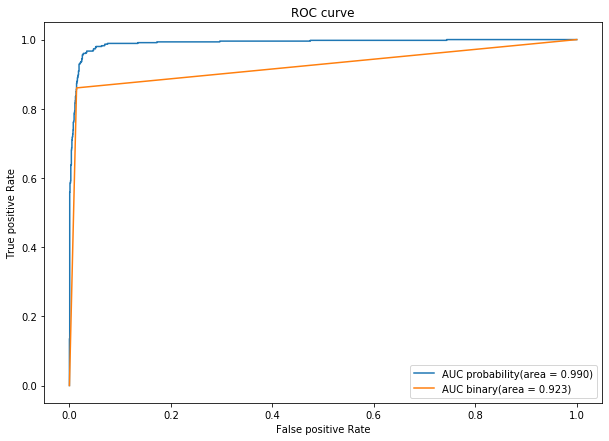

In [0]:
history = model.fit(X_train, y_train)
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test_pred = np.argmax(y_test, axis = 1)
y_pred_prob = model.predict(X_test)
y_test_prob = y_test[:, 1]
y_pred_prob = y_pred_prob[:, 1]

plt.figure(figsize=(10, 7))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_prob, y_pred_prob)
AUC_prob = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='AUC probability(area = {:.3f})'.format(AUC_prob))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_pred, y_pred)
AUC_acc = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='AUC binary(area = {:.3f})'.format(AUC_acc))

plt.xlabel('False positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
print(classification_report(y_test_pred, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1849
           1       0.94      0.86      0.90       451

    accuracy                           0.96      2300
   macro avg       0.95      0.92      0.94      2300
weighted avg       0.96      0.96      0.96      2300



# 1-Dimensional Convolutional Neural Network

A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling1D
from keras.callbacks import LearningRateScheduler
from keras import regularizers

In [0]:
y = df_copy['y']
X = df_copy.drop(['y', 'patient_id', 'sec'], axis=1)
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = utils.to_categorical(y_train, 2)
y_test = utils.to_categorical(y_test, 2)
# reshape for fitting a model in a way: (number_of_samples, number_of_time_points, number_of_channels)
X_train = X_train.reshape(-1,178,1) 
X_test = X_test.reshape(-1,178,1)

In [0]:
# create a model
model = Sequential()
# create first convolutional layer with 32 filters of sliding window width 5
model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train.shape[1:])))
# additional convolutional layer allows model to learn more complex features
model.add(Conv1D(32, 5, activation='relu'))
# use max pooling to reduce size of feature matrix
model.add(MaxPooling1D())
# the same for second set of convolutional layers
model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
# last layer
model.add(Dense(2, activation='softmax'))
# model should be compiled before fitting
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 174, 32)           192       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 170, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 85, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 81, 64)            10304     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 77, 64)            20544     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [0]:
# TRAIN NETWORKS
epochs = 20
history = model.fit(X_train,y_train, epochs = epochs, validation_split = 0.1, verbose=1)
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,max(history.history['acc']),max(history.history['val_acc']) ))

Train on 8280 samples, validate on 920 samples
Epoch 1/20
8280/8280 [==============================] - 7s 899us/sample - loss: 0.1835 - acc: 0.9290 - val_loss: 0.1334 - val_acc: 0.9435
Epoch 2/20
8280/8280 [==============================] - 7s 884us/sample - loss: 0.1077 - acc: 0.9553 - val_loss: 0.1415 - val_acc: 0.9446
Epoch 3/20
8280/8280 [==============================] - 7s 890us/sample - loss: 0.0893 - acc: 0.9640 - val_loss: 0.1235 - val_acc: 0.9576
Epoch 4/20
8280/8280 [==============================] - 7s 888us/sample - loss: 0.0756 - acc: 0.9746 - val_loss: 0.0782 - val_acc: 0.9750
Epoch 5/20
8280/8280 [==============================] - 7s 891us/sample - loss: 0.0568 - acc: 0.9801 - val_loss: 0.0684 - val_acc: 0.9826
Epoch 6/20
8280/8280 [==============================] - 7s 887us/sample - loss: 0.0500 - acc: 0.9820 - val_loss: 0.0657 - val_acc: 0.9772
Epoch 7/20
8280/8280 [==============================] - 7s 888us/sample - loss: 0.0471 - acc: 0.9845 - val_loss: 0.0563 - val

Best train acc:  0.9905797
Best validation acc:  0.9836956


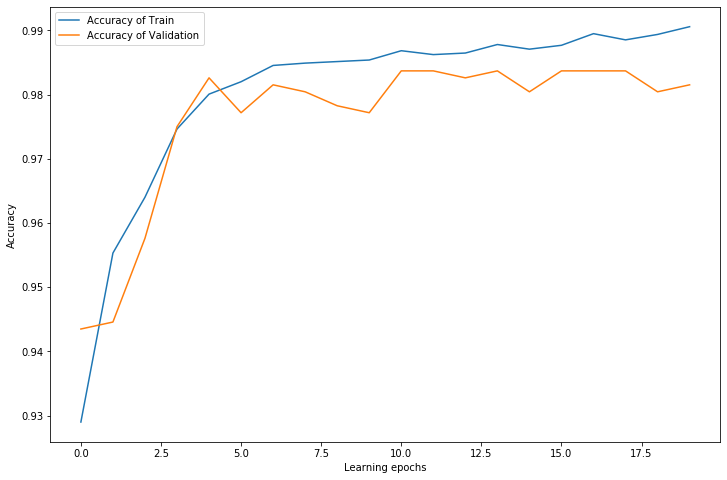

In [0]:
print('Best train acc: ', max(history.history['acc']))
print('Best validation acc: ', max(history.history['val_acc']))
plt.figure(figsize=(12, 8))
plt.xlabel('Learning epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], 
         label='Accuracy of Train')
plt.plot(history.history['val_acc'], 
         label='Accuracy of Validation')
plt.legend()

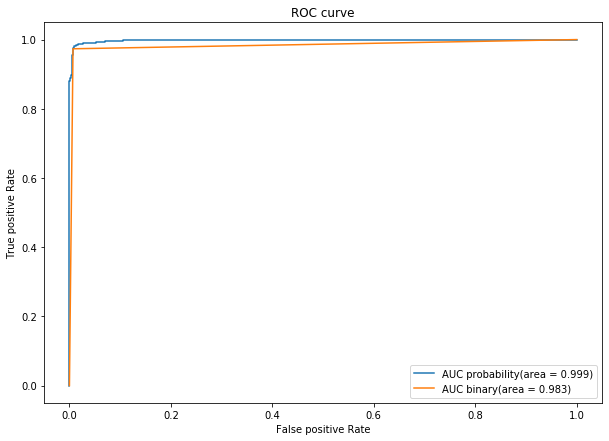

In [0]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test_pred = np.argmax(y_test, axis = 1)
y_pred_prob = model.predict(X_test)
y_test_prob = y_test[:, 1]
y_pred_prob = y_pred_prob[:, 1]

plt.figure(figsize=(10, 7))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_prob, y_pred_prob)
AUC_prob = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='AUC probability(area = {:.3f})'.format(AUC_prob))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_pred, y_pred)
AUC_acc = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='AUC binary(area = {:.3f})'.format(AUC_acc))

plt.xlabel('False positive Rate')
plt.ylabel('True positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()